In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pyxdf
import mne
import pandas as pd


from matplotlib.colors import TwoSlopeNorm
import seaborn as sns
from mne.datasets import eegbci
from mne.io import concatenate_raws, read_raw_edf
from mne.time_frequency import tfr_multitaper
from mne.stats import permutation_cluster_1samp_test as pcluster_test

%matplotlib widget

In [1]:
pip install ipympl

     ---------------------------------------- 0.0/511.6 kB ? eta -:--:--
     ---------------------------- --------- 389.1/511.6 kB 8.2 MB/s eta 0:00:01
     -------------------------------------- 511.6/511.6 kB 8.1 MB/s eta 0:00:00
     ---------------------------------------- 0.0/138.3 kB ? eta -:--:--
     ---------------------------------------- 138.3/138.3 kB ? eta 0:00:00
     ---------------------------------------- 0.0/198.2 kB ? eta -:--:--
     ------------------------------------- 198.2/198.2 kB 12.5 MB/s eta 0:00:00
     ---------------------------------------- 0.0/2.1 MB ? eta -:--:--
     ----------------- ---------------------- 0.9/2.1 MB 29.4 MB/s eta 0:00:01
     ---------------------------------- ----- 1.8/2.1 MB 19.3 MB/s eta 0:00:01
     ---------------------------------------- 2.1/2.1 MB 16.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


## Load & visualize data

In [2]:
DATA_P01 = 'DATA/Pilots_Tobias_05.10.22/'

PASSIVE_OBS_P01 = 'sub-Tobias_passiveOA.xdf'
BASELINE_EO_P01 = 'sub-Tobias_eegBaseline_eyesOpen.xdf'
BASELINE_EC_P01 = 'sub-Tobias_eegBaseline_eyesClosed.xdf'
EEG_MONTAGE = 'DATA/montage_perfect.csv'

In [3]:
fname_p01 = DATA_P01 + PASSIVE_OBS_P01
streams_p01, header_p01 = pyxdf.load_xdf(fname_p01)
data_passive = streams_p01[1]["time_series"].T
trial_series = np.array(streams_p01[2]["time_series"])
trial_times = np.array(streams_p01[2]["time_stamps"])

Stream 4: Calculated effective sampling rate 876.1063 Hz is different from specified rate 999.9999 Hz.


In [4]:
sfreq_passive = float(streams_p01[1]["info"]["nominal_srate"][0])
info_passive = mne.create_info(65, sfreq_passive)
raw_passive = mne.io.RawArray(data_passive*1e-6, info_passive)

Creating RawArray with float64 data, n_channels=65, n_times=1238492
    Range : 0 ... 1238491 =      0.000 ...   619.245 secs
Ready.


In [5]:
def get_index_of_stream_type(streams, type):
    """
    type = 'EEG', 'TargetID'
    return the index of the stream corresponding to the wanted type
    types : 'EEG', 'Markers', 'Unity.Property', 'Unity.Marker'(2 different),
    """
    if type == 'EEG': name = 'eegoSports 000650'
    
    elif type == 'TargetID': name = 'Unity.Marker.TargetID'
    else :
        raise NameError(
            f"given type '{type}' is not an argument. Accepted types are 'EEG' and 'TargetID'"
        )
    for i in range(len(streams)):
        if streams[i]['info']['name'][0] == name:
            return i
    raise NameError(
         f"given type '{type}' cannot be found in any of the streams"
    )

Creating RawArray with float64 data, n_channels=65, n_times=1238492
    Range : 0 ... 1238491 =      0.000 ...   619.245 secs
Ready.


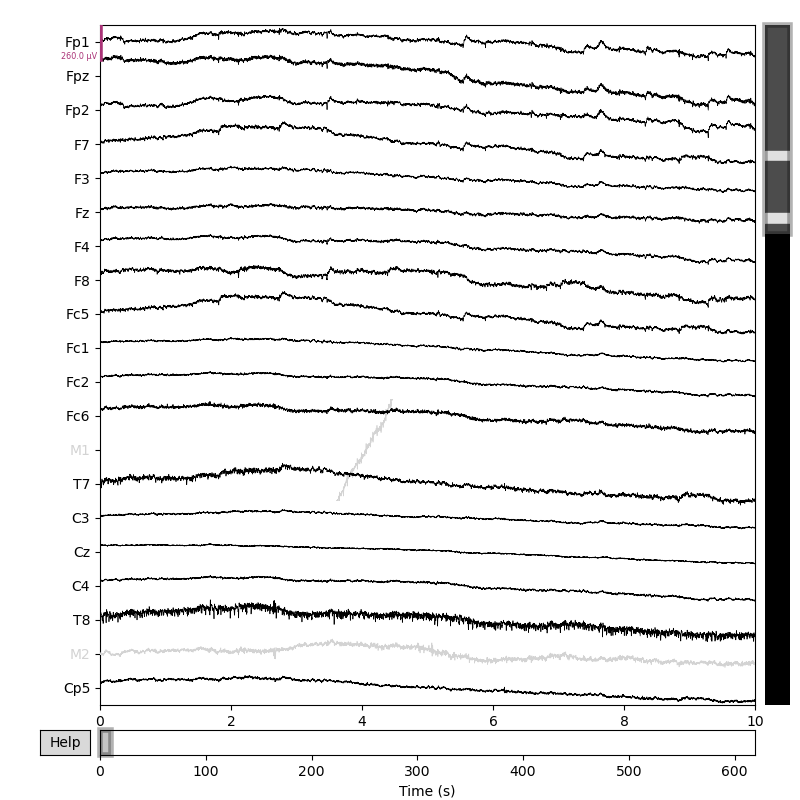

In [61]:
EEG = get_index_of_stream_type(streams_p01, type='EEG')

#channels = streams_p01[1]['info']['desc'][0]['channels'][0]['channel']
#channel_label = []
#channel_type = []
#for element in channels:
 #   channel_label.append(element['label'])
 #   channel_type.append("eeg")
#channel_type[-1] = "stim"
#channel_label = np.reshape(channel_label,(65))

#channel_label = channel_label.tolist()

montage_label = pd.read_csv(EEG_MONTAGE)
channel_label = montage_label['ch_name'].tolist()
channel_label.append('Trigger')

data_passive = streams_p01[EEG]["time_series"].copy().T  * 1e-6
     
sfreq_passive = float(streams_p01[EEG]["info"]["nominal_srate"][0])
ch_types = ['eeg'] * 64 + ['misc']
info_passive = mne.create_info(channel_label, sfreq_passive, ch_types)
raw_passive = mne.io.RawArray(data_passive, info_passive) 

raw_passive.info['bads'].extend(['M1', 'M2'])
raw_passive.plot(scalings=0.00013); 

In [62]:
print(raw_passive.info)

<Info | 8 non-empty values
 bads: 2 items (M1, M2)
 ch_names: Fp1, Fpz, Fp2, F7, F3, Fz, F4, F8, Fc5, Fc1, Fc2, Fc6, M1, T7, ...
 chs: 64 EEG, 1 misc
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 1000.0 Hz
 meas_date: unspecified
 nchan: 65
 projs: []
 sfreq: 2000.0 Hz
>


## Preprocessing (BP and CAR filtering)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.50
- Lower transition bandwidth: 1.50 Hz (-6 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 4401 samples (2.200 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    4.5s finished


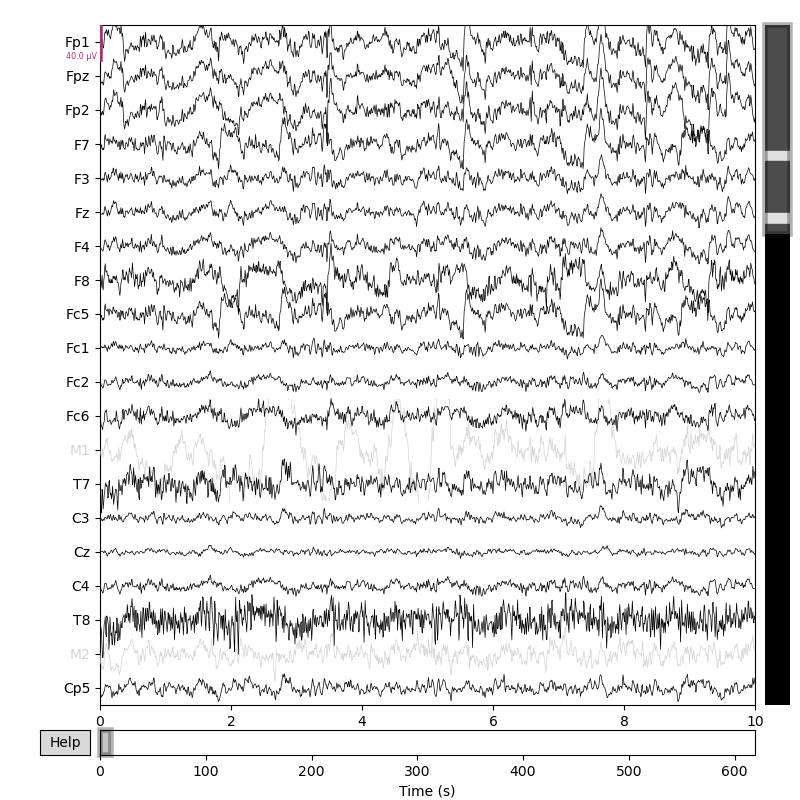

In [63]:
raw_passive_filtered = raw_passive.copy().filter(l_freq=1.5, h_freq=40)
raw_passive_filtered.plot();

In [64]:
raw_passive_filtered.info

<Info | 8 non-empty values
 bads: 2 items (M1, M2)
 ch_names: Fp1, Fpz, Fp2, F7, F3, Fz, F4, F8, Fc5, Fc1, Fc2, Fc6, M1, T7, ...
 chs: 64 EEG, 1 misc
 custom_ref_applied: False
 highpass: 1.5 Hz
 lowpass: 40.0 Hz
 meas_date: unspecified
 nchan: 65
 projs: []
 sfreq: 2000.0 Hz
>

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


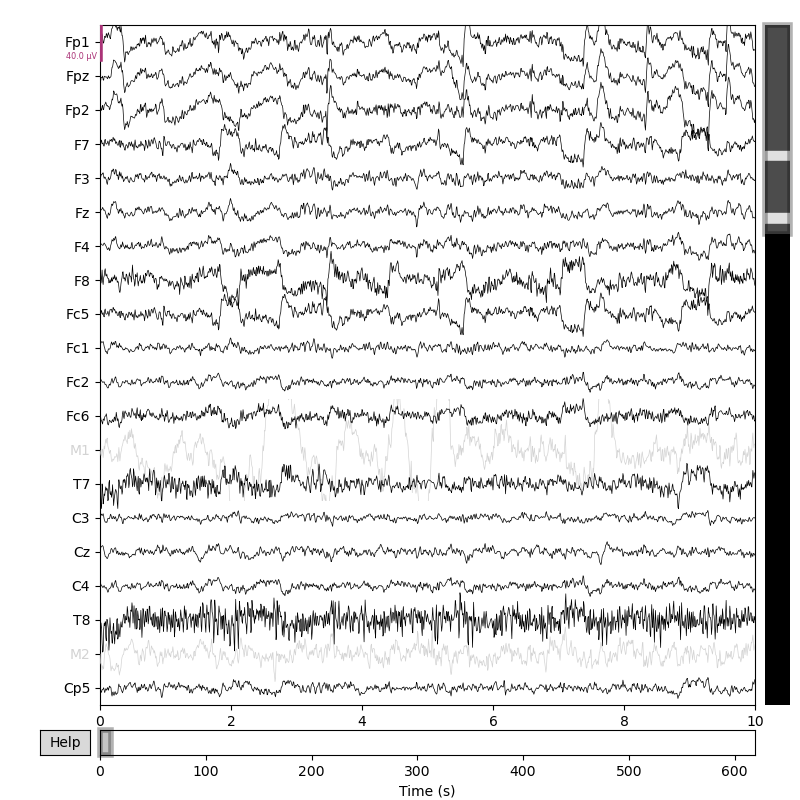

In [65]:
raw_passive_CAR, data_reference = mne.set_eeg_reference(raw_passive_filtered, ref_channels = 'average', copy = True)
raw_passive_CAR.plot();

In [66]:
print(raw_passive_CAR.info)

<Info | 9 non-empty values
 bads: 2 items (M1, M2)
 ch_names: Fp1, Fpz, Fp2, F7, F3, Fz, F4, F8, Fc5, Fc1, Fc2, Fc6, M1, T7, ...
 chs: 64 EEG, 1 misc
 custom_ref_applied: True
 highpass: 1.5 Hz
 lowpass: 40.0 Hz
 meas_date: unspecified
 nchan: 65
 projs: []
 sfreq: 2000.0 Hz
>


## Baseline measurements

In [9]:
fname_p01 = DATA_P01 + PASSIVE_OBS_P01
fnames_baseline_p01 = ([DATA_P01 + BASELINE_EC_P01, DATA_P01 + BASELINE_EO_P01])
streams_baseline_eo, header_baseline_eo = pyxdf.load_xdf(fnames_baseline_p01[0])
streams_baseline_ec, header_baseline_ec = pyxdf.load_xdf(fnames_baseline_p01[1])
data_baseline_eo = streams_baseline_eo[1]["time_series"].T
data_baseline_ec = streams_baseline_ec[1]["time_series"].T

Stream 2: Calculated effective sampling rate 831.9506 Hz is different from specified rate 999.9999 Hz.


In [10]:
sfreq_baseline_eo = float(streams_baseline_eo[1]["info"]["nominal_srate"][0])
info_baseline_eo = mne.create_info(65, sfreq_baseline_eo)
raw_baseline_eo = mne.io.RawArray(data_baseline_eo*1e-6, info_baseline_eo)

Creating RawArray with float64 data, n_channels=65, n_times=367031
    Range : 0 ... 367030 =      0.000 ...   183.515 secs
Ready.


Creating RawArray with float64 data, n_channels=65, n_times=367031
    Range : 0 ... 367030 =      0.000 ...   183.515 secs
Ready.


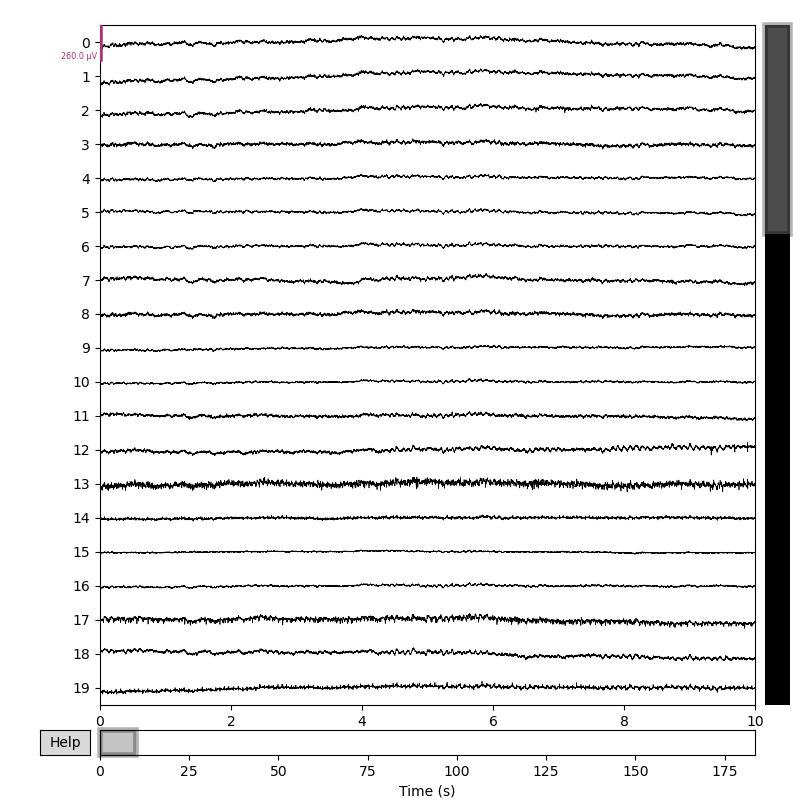

In [11]:
EEG = get_index_of_stream_type(streams_baseline_eo, type='EEG')

data_baseline_eo = streams_baseline_eo[EEG]["time_series"].copy().T  * 1e-6
     
sfreq_baseline_eo = float(streams_baseline_eo[EEG]["info"]["nominal_srate"][0])
ch_types = ['eeg'] * 64 + ['misc']
info_baseline_eo = mne.create_info(65, sfreq_baseline_eo, ch_types)
raw_baseline_eo = mne.io.RawArray(data_baseline_eo, info_baseline_eo)
raw_baseline_eo.plot(scalings=0.00013);  

In [12]:
trial_series = trial_series.reshape(71)
trial_series = trial_series.astype(int)

In [13]:
trial_series 

array([8, 8, 8, 5, 8, 8, 8, 5, 2, 8, 5, 5, 8, 8, 2, 2, 8, 2, 2, 2, 5, 5,
       5, 5, 5, 2, 2, 2, 5, 2, 8, 5, 8, 2, 5, 2, 8, 8, 8, 5, 8, 8, 8, 5,
       2, 8, 5, 5, 8, 8, 2, 2, 8, 2, 2, 2, 5, 5, 5, 5, 5, 2, 2, 2, 5, 2,
       8, 5, 8, 2, 5])

In [14]:
trial_times

array([60394.98114969, 60402.34113953, 60409.71384134, 60416.8467446 ,
       60424.22900602, 60431.92318222, 60439.61501337, 60446.96884303,
       60454.70442974, 60461.8743485 , 60469.35958437, 60476.96079463,
       60484.161715  , 60491.56907425, 60499.30157782, 60506.71562204,
       60514.11768489, 60521.49190316, 60529.28255173, 60536.66603333,
       60544.18173852, 60551.23739095, 60558.36327414, 60565.74256902,
       60572.89395953, 60580.24872497, 60587.49509708, 60594.67153951,
       60602.19605963, 60609.25602017, 60616.53109553, 60623.99431072,
       60631.40448421, 60639.0255125 , 60646.44319365, 60653.84993521,
       60660.90269549, 60668.43159933, 60676.0535744 , 60683.56315361,
       60690.99794683, 60698.64189589, 60706.37380217, 60713.74259025,
       60721.49519944, 60728.66283354, 60736.83561796, 60746.07415913,
       60756.45906084, 60765.11692054, 60774.3563497 , 60783.15933675,
       60791.90271183, 60800.68498897, 60810.12198267, 60819.59070148,
      

In [15]:
events = np.concatenate((trial_times, np.zeros(len(trial_series)),trial_series))

In [16]:
events = events.reshape(71,3, order = 'F')
events = events.astype(int)

In [17]:
epochs = mne.Epochs(raw_passive, events)

Not setting metadata
71 matching events found
Setting baseline interval to [-0.2, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated


## Epochs

In [67]:
time_offset = 1
duration = 5
trial_id = get_index_of_stream_type(streams_p01, 'TargetID')

In [68]:
reset_time = streams_p01[EEG]['time_stamps'][0]
trial_time = streams_p01[trial_id]['time_stamps'] - reset_time

In [69]:
targets = np.array(streams_p01[trial_id]['time_series']).squeeze()
annotations = mne.Annotations(onset = trial_time, duration = 0., description = targets)

In [70]:
data_annotated = raw_passive_CAR.copy().set_annotations(annotations)
events_p01, event_id_p01 = mne.events_from_annotations(data_annotated)
epochs_p01 = mne.Epochs(raw_passive_CAR, events_p01, event_id_p01, tmin=-time_offset, tmax = duration, baseline = (-time_offset,0), reject=dict(eeg=400e-6), preload=True)

Used Annotations descriptions: ['2', '5', '8']
Not setting metadata
71 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 71 events and 12001 original time points ...
0 bad epochs dropped


In [71]:
print(epochs_p01.info)

<Info | 9 non-empty values
 bads: 2 items (M1, M2)
 ch_names: Fp1, Fpz, Fp2, F7, F3, Fz, F4, F8, Fc5, Fc1, Fc2, Fc6, M1, T7, ...
 chs: 64 EEG, 1 misc
 custom_ref_applied: True
 highpass: 1.5 Hz
 lowpass: 40.0 Hz
 meas_date: unspecified
 nchan: 65
 projs: []
 sfreq: 2000.0 Hz
>


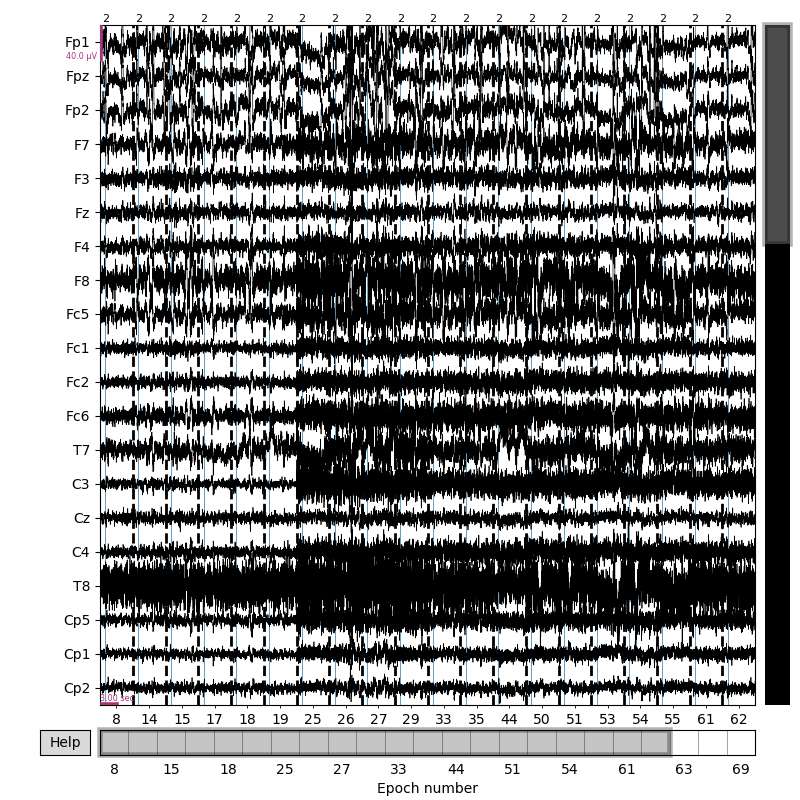

In [72]:
epochs_p01['2'].plot(events=events_p01, event_id=event_id_p01); 

In [73]:
#evoked = epochs.average()
#evoked.info.set_montage(montage)
#times = np.arange(0.1, 5, 0.8)
#evoked.plot_topomap(times, sphere = 'eeglab');

## Topoplot

/var/folders/2n/bx0lrs_93yv_pk012x7gvfnr0000gn/T/ipykernel_19603/404951762.py:3: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  evoked.info.set_montage(eeg_montage)


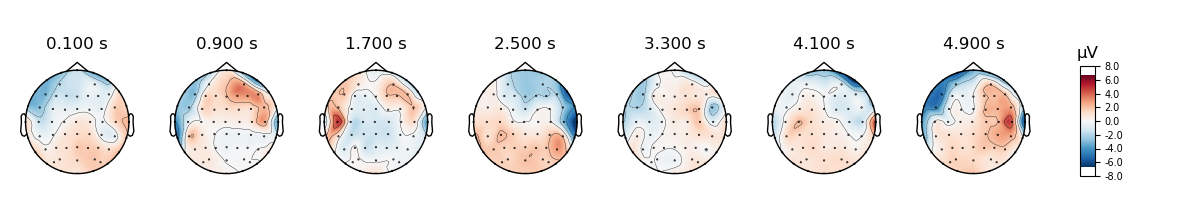

In [74]:
eeg_montage = mne.channels.read_custom_montage(EEG_MONTAGE) 
evoked = epochs_p01['5'].average()
evoked.info.set_montage(eeg_montage)
times = np.arange(0.1, 5, 0.8)
evoked.plot_topomap(times, sphere='eeglab'); 

## ERD/ERS

In [115]:
freqs_p01 = np.arange(1.5, 30)
vmin, vmax = -1, 1.5  # set min and max ERDS values in plot ??
baseline = (-time_offset, 0)
cnorm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax) 

kwargs = dict(n_permutations=100, step_down_p=0.05, seed=1,
              buffer_size=None, out_type='mask')  

epochs_p01_resampled = epochs_p01.resample(200)

In [116]:
epochs_p01_resampled.info

<Info | 9 non-empty values
 bads: 2 items (M1, M2)
 ch_names: Fp1, Fpz, Fp2, F7, F3, Fz, F4, F8, Fc5, Fc1, Fc2, Fc6, M1, T7, ...
 chs: 64 EEG, 1 misc
 custom_ref_applied: True
 highpass: 1.5 Hz
 lowpass: 40.0 Hz
 meas_date: unspecified
 nchan: 65
 projs: []
 sfreq: 200.0 Hz
>

In [124]:
epochs_MI = epochs_p01_resampled.copy().pick_channels(['C1', 'C2', 'C3', 'Cz', 'C4', 'C5', 'C6'])

In [125]:
epochs_MI.info

<Info | 8 non-empty values
 bads: []
 ch_names: C3, Cz, C4, C5, C1, C2, C6
 chs: 7 EEG
 custom_ref_applied: True
 highpass: 1.5 Hz
 lowpass: 40.0 Hz
 meas_date: unspecified
 nchan: 7
 projs: []
 sfreq: 200.0 Hz
>

In [126]:
tfr = tfr_multitaper(epochs_MI, freqs=freqs_p01, n_cycles=freqs_p01, use_fft=True,
                     return_itc=False, average=False, decim=2)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.9s remaining:    0.0s


Not setting metadata


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    1.5s finished


In [127]:
tfr.crop(-time_offset, duration).apply_baseline(baseline, mode="percent")

Applying baseline correction (mode: percent)


/var/folders/2n/bx0lrs_93yv_pk012x7gvfnr0000gn/T/ipykernel_19603/893199419.py:1: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.EpochsTFR'>.tmax (4.99 sec)
  tfr.crop(-time_offset, duration).apply_baseline(baseline, mode="percent")


<EpochsTFR | time : [-1.000000, 4.990000], freq : [1.500000, 29.500000], epochs : 71, channels : 7, ~66.0 MB>

In [128]:
df = tfr.to_data_frame(time_format = None, long_format = True)

Converting "condition" to "category"...
Converting "epoch" to "category"...
Converting "freq" to "category"...
Converting "channel" to "category"...
Converting "ch_type" to "category"...


Applying baseline correction (mode: mean)


/var/folders/2n/bx0lrs_93yv_pk012x7gvfnr0000gn/T/ipykernel_19603/3819093279.py:3: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  evoked.info.set_montage(eeg_montage)


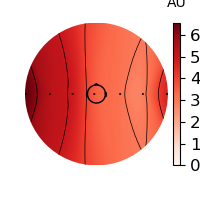

In [129]:
eeg_montage = mne.channels.read_custom_montage(EEG_MONTAGE) 
evoked = tfr['2'].average()
evoked.info.set_montage(eeg_montage)
evoked.plot_topomap(0.1, 5,baseline = baseline); 

In [131]:
df = tfr.to_data_frame(time_format=None, long_format=True)
df

Converting "condition" to "category"...
Converting "epoch" to "category"...
Converting "freq" to "category"...
Converting "channel" to "category"...
Converting "ch_type" to "category"...


condition epoch  freq  time channel ch_type     value
0               8     0   1.5 -1.00      C3     eeg -0.709830
1               8     0   1.5 -1.00      Cz     eeg -0.948124
2               8     0   1.5 -1.00      C4     eeg -0.807099
3               8     0   1.5 -1.00      C5     eeg -0.399160
4               8     0   1.5 -1.00      C1     eeg -0.951160
...           ...   ...   ...   ...     ...     ...       ...
8647795         5    70  29.5  4.99      C4     eeg  0.599722
8647796         5    70  29.5  4.99      C5     eeg -0.948236
8647797         5    70  29.5  4.99      C1     eeg -0.971026
8647798         5    70  29.5  4.99      C2     eeg  0.734512
8647799         5    70  29.5  4.99      C6     eeg -0.915078

[8647800 rows x 7 columns]

In [132]:
# Map to frequency bands:
freq_bounds = {'_': 0,
               'delta': 3,
               'theta': 7,
               'alpha': 13,
               'beta': 30,}
df['band'] = pd.cut(df['freq'], list(freq_bounds.values()),
                    labels=list(freq_bounds)[1:])

In [133]:
# Filter to retain only relevant frequency bands:
freq_bands_of_interest = ['alpha', 'beta']
df = df[df.band.isin(freq_bands_of_interest)]
df['band'] = df['band'].cat.remove_unused_categories()

/var/folders/2n/bx0lrs_93yv_pk012x7gvfnr0000gn/T/ipykernel_19603/688691845.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['band'] = df['band'].cat.remove_unused_categories()


In [134]:
df['channel'] = df['channel'].cat.reorder_categories(('C1', 'C2', 'C3', 'Cz', 'C4', 'C5', 'C6'),
                                                     ordered=True)

/var/folders/2n/bx0lrs_93yv_pk012x7gvfnr0000gn/T/ipykernel_19603/54802324.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['channel'] = df['channel'].cat.reorder_categories(('C1', 'C2', 'C3', 'Cz', 'C4', 'C5', 'C6'),


In [135]:
g = sns.FacetGrid(df, row='band', col='channel', margin_titles=True)
g.map(sns.lineplot, 'time', 'value', 'condition', n_boot=10)
axline_kw = dict(color='black', linestyle='dashed', linewidth=0.5, alpha=0.5)
g.map(plt.axhline, y=0, **axline_kw)
g.map(plt.axvline, x=0, **axline_kw)
g.set(ylim=(None, 1.5))
g.set_axis_labels("Time (s)", "ERDS (%)")
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.add_legend(ncol=2, loc='lower center')
g.fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.08)

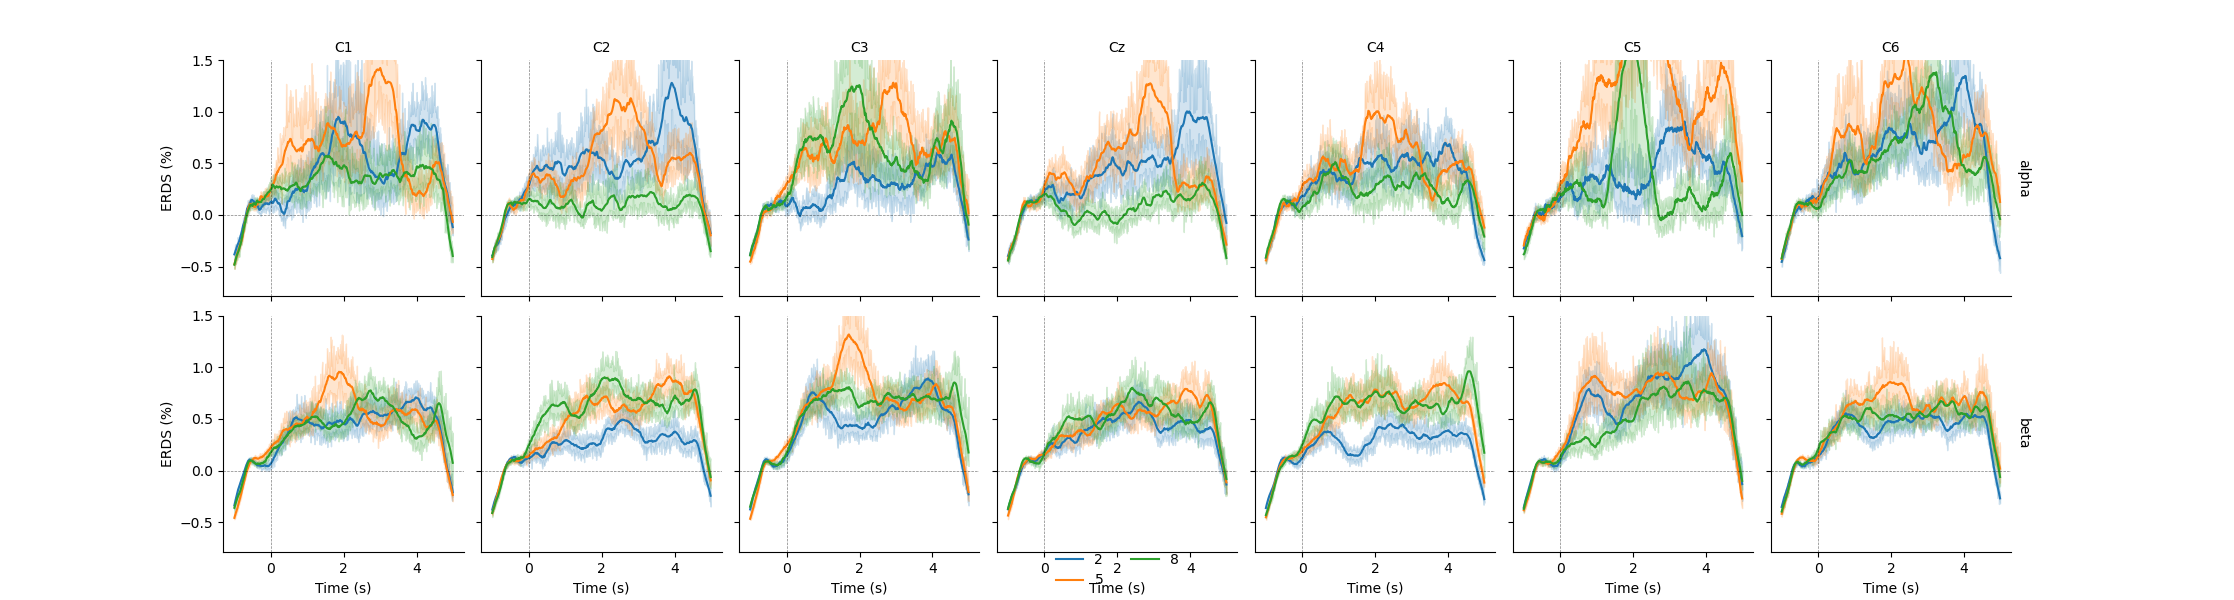

In [139]:
plt.show()